# Predição de Fraudes Automotivas

Notebook em Python dedicado à execução da metodologia proposta no trabalho "Análise Preditiva Aplicada à Identificação de Fraudes em Seguros Automotivos". Disponível em: [Overleaf](https://www.overleaf.com/project/68239ce713d965d268b7699b).

As seções a seguir descrevem, em detalhes, todas as etapas necessárias para a reprodução do processo de treinamento dos modelos de aprendizado para predição propostos pelo trabalho. A primeira seção, Preparations, abrange a formatação dos dados e preparação do dataframe para treinamento, além da criação dos conjuntos de treinamento e teste. Para a segunda seção, é descrito o algoritmo de SMOTE (Synthetic Minority Over-sampling Technique), utilizado para balanceamento dos dados. Vale ressaltar que, essa célula é opcional, uma vez que, o experimento é dedicado a comparar os resultados do treinamento de dados balanceados e desbalanceados. Na sequência, a seção Model Training é responsável pelo treinamento de todos os modelos abordados, utilizando os conjuntos preparados anteriormente. Por fim, a seção Results apresenta a comparação dos resultados obtidos para cada modelo treinado, exibindo as métricas de acurácia, precisão, revoção e f1-score coletadas durante a fase de treinamento.

Para esse experimento foram utilizadas as bibliotecas de código publico: [kagglehub](https://github.com/Kaggle/kagglehub), [pandas](https://pandas.pydata.org/), [seaborn](https://seaborn.pydata.org/), [matplotlib](https://matplotlib.org/), [sklearn](https://scikit-learn.org/stable/), [imblearn](https://imbalanced-learn.org/stable/).

Como referência para a implementação, foi utilizado o seguinte artigo disponibilizado no Kaggle: [Artigo](https://www.kaggle.com/code/hobeomlee/fraud-detection-modeling-guidebook-a-to-z)

## Preparations

### Imports

Etapa de imports das bibliotecas utilizadas; Download do dataset utilizando a lib `kagglehub`; Declaração de variáveis e funções utilitárias.

In [1]:
# Imports

import kagglehub
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Import dataset from Kaggle and generate dataframe
path = kagglehub.dataset_download("shivamb/vehicle-claim-fraud-detection")
fraud_df = pd.read_csv(path + '/fraud_oracle.csv')

In [3]:
# Helper functions & variables

balanced = False

results = []

def calculate_results(model_name, y_test_target, y_pred_result, balanced):
    # Calcula métricas
    accuracy = accuracy_score(y_test_target, y_pred_result)
    precision = precision_score(y_test_target, y_pred_result, zero_division=0)
    recall = recall_score(y_test_target, y_pred_result, zero_division=0)
    f1 = f1_score(y_test_target, y_pred_result, zero_division=0)

    # Adiciona os resultados à lista global
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "SMOTE": "Yes" if balanced else "No"
    })

    # Exibe os resultados na célula
    print(f"Modelo: {model_name}")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Revocação: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("-" * 30)


### Encoding



Essa etapa é responsável por realizar o `encoding` do dataframe utilizando algoritmos de estratégia binária para colunas com valores de categorias booleanas; One-hot para categorias com mais de dois valores de categoria; Ordinal para as colunas VehiclePrice e AgeOfVehicle.

In [4]:
# Encoding DF for ML

# Binary
binary_columns = [col for col in fraud_df.columns if fraud_df[col].nunique() == 2 and col != 'FraudFound_P']
for col in binary_columns:
    fraud_df[col] = LabelEncoder().fit_transform(fraud_df[col])

# Onehot
fraud_df = pd.get_dummies(fraud_df, columns=['Make', 'MonthClaimed', 'MaritalStatus', 'PolicyType', 'VehicleCategory',
                                             'RepNumber', 'Deductible', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims',
                                             'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year', 'BasePolicy'])

# Ordinal
price_categories = [['less than 20000', '20000 to 29000', '30000 to 39000', '40000 to 59000', '60000 to 69000', 'more than 69000']]
age_categories = [['new', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', 'more than 7']]

price_encoder = OrdinalEncoder(categories=price_categories)
age_encoder = OrdinalEncoder(categories=age_categories)

fraud_df['VehiclePrice'] = price_encoder.fit_transform(fraud_df[['VehiclePrice']])
fraud_df['AgeOfVehicle'] = age_encoder.fit_transform(fraud_df[['AgeOfVehicle']])


### Dropping columns

Essa etapa é responsável por remover colunas específicas do dataframe. Não será necessário utilizar essas colunas devido a sua irrelevância para o experimento.

In [5]:
# Drop useless columns
fraud_df = fraud_df.drop(['Month', 'WeekOfMonth', 'DayOfWeek', 'DayOfWeekClaimed', 'WeekOfMonthClaimed', 'PolicyNumber'], axis=1)

### Trainning and tests sets creation



Esta etapa é responsável por construir os conjuntos de treino e teste.
Para o conjunto `x`, removemos a coluna binária `FraudFound_P`, pois ele representa nosso conjunto de *features*. Já para o conjunto `y`, mantemos essa coluna, pois ela é o alvo (*target*) da validação.

Optamos por uma divisão de 80-20 entre treino e teste, proporcionando maior exposição aos dados durante o treinamento do modelo.

**Parâmetros em destaque**:
* `test_size`: Porcentagem do dataframe a ser utilizada como conjunto de testes.

In [6]:
# Create feature and target dataframes, Create train-test split for trainning and testing sets
x = fraud_df.drop(['FraudFound_P'], axis=1)
y = fraud_df['FraudFound_P']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
x_train.shape, x_test.shape

((12336, 120), (3084, 120))

## Balancing


Esta célula deve ser executada caso o objetivo do experimento seja gerar um resultado baseado no balanceamento do dataframe.

Utilizamos oversampling através do algoritmo de SMOTE para balanceamento da coluna `FraudFound_P` uma vez que, inicialmente, ela está desbalanceada.

**Disclaimer**: O SMOTE não aumenta o número de atributos ou explora o dataset "pequeno", mas sim direciona o aprendizado do modelo para melhor identificar a classe minoritária. Ele resolve isso ao gerar novas instâncias sintéticas da classe minoritária utilizando os dados existentes dessa classe, criando amostras intermediárias (com base nos vizinhos mais próximos) e expandindo o conjunto de treinamento com as instâncias geradas.

**Parâmetros em destaque**:
* `random_state`: A viés de reprodução do experimento, essa variável possui um valor arbitrário que controla a variabilidade da geração de dados sintéticos.
* `balanced`: Variável de controle para identificação posterior se o dataframe foi balanceado.

In [7]:
# Handling imbalance with oversampling

smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)
balanced_df = pd.concat([x_train, y_train], axis=1)

balanced = True

## Model Trainning

### Logistic Regression

Esse seção apresenta a implementação do modelo de Regressão Logistica para a predição de fraudes.

Como estamos comparando o treinamento baseado na vertente do balanceamento de dados, precisamos verificar se essa etapa foi realizada anteriormente. Para isso, olhamos para a variável `balanced`, em caso de balanceamento, ajustamos o máximo de iterações de treinamento para o valor default: `100`. Do contrário, com um conjunto de dados menor, precisamos iterar mais vezes sob o conjunto treinamento para. Para isso, incremetamos o valor default sob si mesmo, até que fosse atingido uma margem de resultados satisfátorios. Mostrou-se satisfatória a definicação de 10x o valor default de iterações, atingindo resultados comparáveis ao treinamento com balanceamento do conjunto.

**Parâmetros em destaque:**
* `balanced`: Variável de controle para identificação posterior se o dataframe foi balanceado.
* `max_iter`: Variável para controle do número de iterações de treinamento para regressão logistica.


In [8]:
# Logistic Regression
if balanced:
    max_iter = 100
else:
    max_iter = 1000

lr = LogisticRegression(max_iter=max_iter, random_state=0)
lr.fit(x_train, y_train)

y_pred_lr = lr.predict(x_test)

calculate_results("Logistic Regression", y_test, y_pred_lr, balanced)

Modelo: Logistic Regression
Acurácia: 0.9397
Precisão: 0.3571
Revocação: 0.0275
F1-Score: 0.0510
------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### SVM

Esta célula implementa o SVM no modelo SVC, utilizado para a classificação. Para os dois casos, foi utilizado o kernel RBF, uma vez que, os dados não são linearmente separaveis em alta dimensão.

O parâmetro `C` determina a regularização dos dados em relação a classificação correta dos exemplos de treinamento e a maximização da margem da função de decisão. Um parâmetro `C` com valores menores, encoraja uma margem maior, portanto, uma função de decisão mais simples aos custos de uma acurácia menor.

Testamos valores para o parâmetro `C`, começando em 1000 e incrementando com o mesmo. Definimos que, a configuração `C=10000` se provou mais satisfatória para a geração de métricas em relação ao tamanho do conjunto de dados, ilustrando um cenário de baixa generalização e foco no treinamento.



**Disclaimer**: Após o encoding e a aplicação do SMOTE, os dados tornaram-se mais complexos e de alta dimensionalidade, dificultando a separação linear entre classes e trazendo falhas no kernel linear. O kernel RBF foi escolhido por sua capacidade de projetar os dados em um espaço onde superfícies de decisão não lineares possam ser aprendidas, o que se mostrou mais eficaz nesse cenário. Nesse sentido, não é necessário especificar o kernel, caso ele seja o RBF, uma vez que o SVC passa o tipo implicitamente na construção do objeto do modelo.

**Parâmetros em destaque:**
* `C`: Parâmetro de regularização dos dados no modelo SVM.

In [9]:
# SVC - RBF Kernel

svc=SVC(C=10000)
svc.fit(x_train,y_train)
y_pred_svc=svc.predict(x_test)

calculate_results("SVM - RBF Kernel", y_test, y_pred_svc, balanced)

Modelo: SVM - RBF Kernel
Acurácia: 0.9400
Precisão: 0.4444
Revocação: 0.0659
F1-Score: 0.1148
------------------------------


### Naive Bayes

Esta célula implementa a predição de dados utilizando o algoritmo de Naive Bayes.

No GaussianNB, para cada classe, calcula-se amédia (μ) e o desvio padrão (σ) das variáveis contínuas durante o treinamento. No momento da predição, usa-se a fórmula da função densidade de probabilidade da distribuição normal para calcular a probabilidade de algo pertencer a uma classe, com base na entrada.



In [10]:
# Gaussian Naive Bayes
naiveB = GaussianNB()
naiveB.fit(x_train, y_train)

y_pred_naiveB = naiveB.predict(x_test)

calculate_results("Naive Bayes", y_test, y_pred_naiveB, balanced)

Modelo: Naive Bayes
Acurácia: 0.2007
Precisão: 0.0655
Revocação: 0.9451
F1-Score: 0.1225
------------------------------


### Random Forest

Está célula implementa o algoritmo de Random Forest

O Random Forest combina a saída de múltiplas árvores de decisão independentes. Cada árvore é criada usando um subconjunto aleatório dos dados do treinamento e também um subconjunto aleatório dos atributos. O objetivo principal é mitigar os erros individuais de uma única árvore e melhorar a generalização do modelo.

- Para problemas de classificação, as previsões de todas as árvores são baseadas em votação majoritária (a classe mais escolhida pelas árvores é selecionada).
- Para problemas de regressão, a saída final é a média das previsões de todas as árvores.

**Parâmetros em destaque:**
* `random_state`: Parâmetro de randomização dos dados afim de garantir reprodutibilidade.



In [11]:
# Random Forest
random_forest = RandomForestClassifier(random_state=0)
random_forest.fit(x_train, y_train)

y_pred_random_forest = random_forest.predict(x_test)

calculate_results("Random Forest", y_test, y_pred_random_forest, balanced)

Modelo: Random Forest
Acurácia: 0.9410
Precisão: 0.5000
Revocação: 0.0495
F1-Score: 0.0900
------------------------------


## Results

Etapa dedicada a exibição dos resultados obtidos anteriormente para o treinamento de cada modelo de aprendizado. Foi utilizado a biblioteca matplotlib para a plotagem de gráficos que ilustram a acurácia, precisão, f1-score e revocação para cada um dos treinamentos executados.

Além disso, cada gráfico possuí uma legenda que identifica se foi feito o uso do algoritmo de SMOTE no balanceamento do conjunto de dados.

### Acurácia

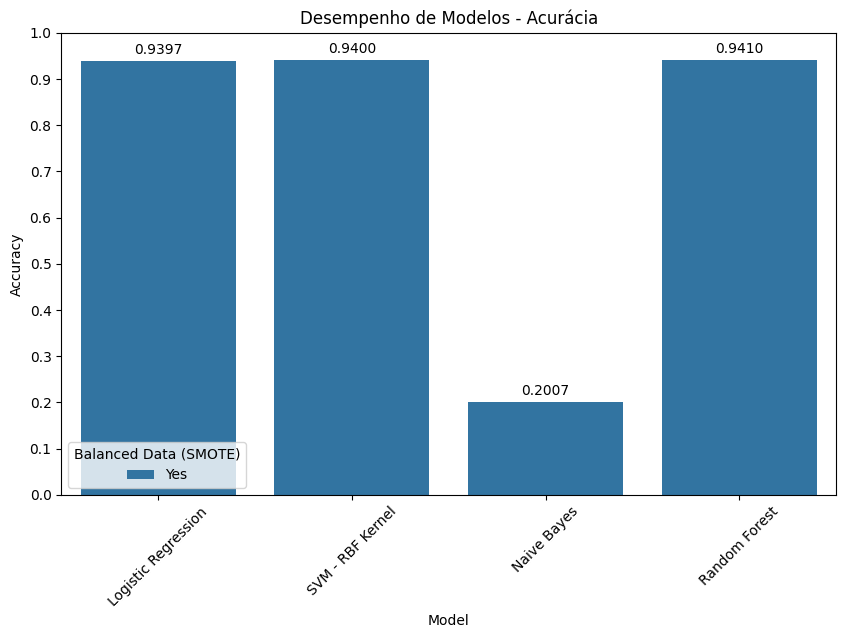

In [12]:
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))

# Criar o gráfico de barras
ax = sns.barplot(x="Model", y="Accuracy", hue="SMOTE", data=results_df)
plt.title("Desempenho de Modelos - Acurácia")
plt.ylabel("Accuracy")
plt.xlabel("Model")

# Ajustar os limites do eixo Y para incluir valores baixos (como 0.20)
plt.ylim(0.0, 0.9)  # De 0 a 1 para incluir toda a variação
plt.yticks(ticks=[i/10 for i in range(0, 11)])  # Incrementos de 0.1

# Exibir os valores diretamente acima das barras (independente da altura)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3)

# Ajustar a legenda e o formato
plt.legend(title="Balanced Data (SMOTE)")
plt.xticks(rotation=45)

# Mostrar o gráfico
plt.show()

### F1-Score

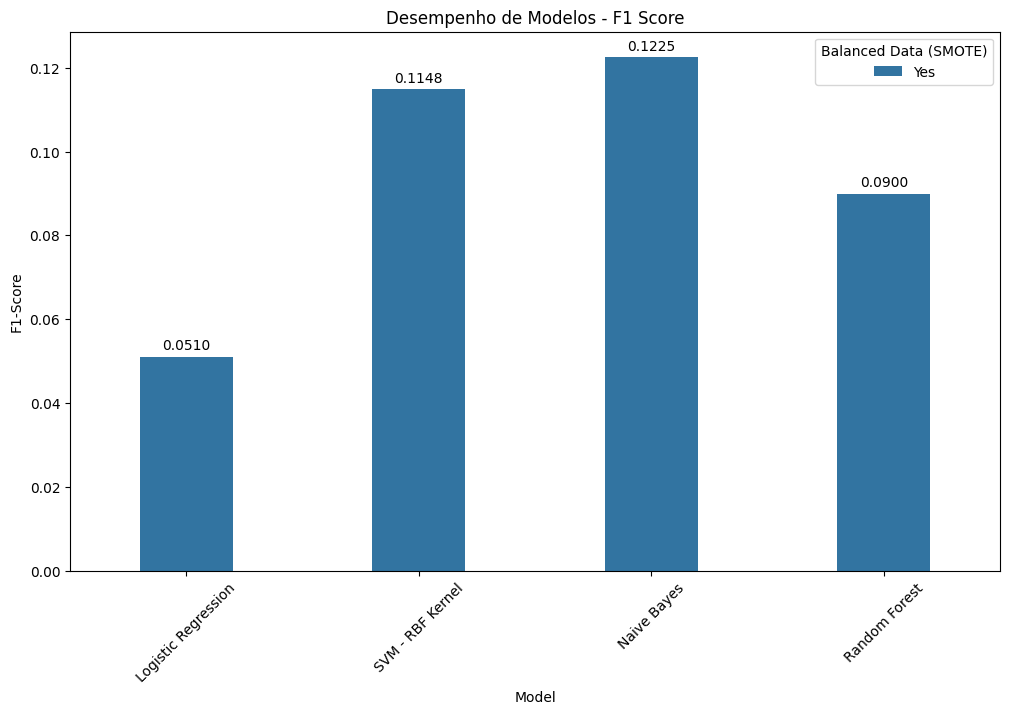

In [13]:
# RQ3: Comparação entre distribuições balanceadas e não balanceadas
plt.figure(figsize=(12, 7))
ax = sns.barplot(x="Model", y="F1-Score", hue="SMOTE", data=results_df,width=0.4)
plt.title("Desempenho de Modelos - F1 Score")
plt.ylabel("F1-Score")
plt.xlabel("Model")
plt.legend(title="Balanced Data (SMOTE)")
plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3)

plt.show()

### Precisão

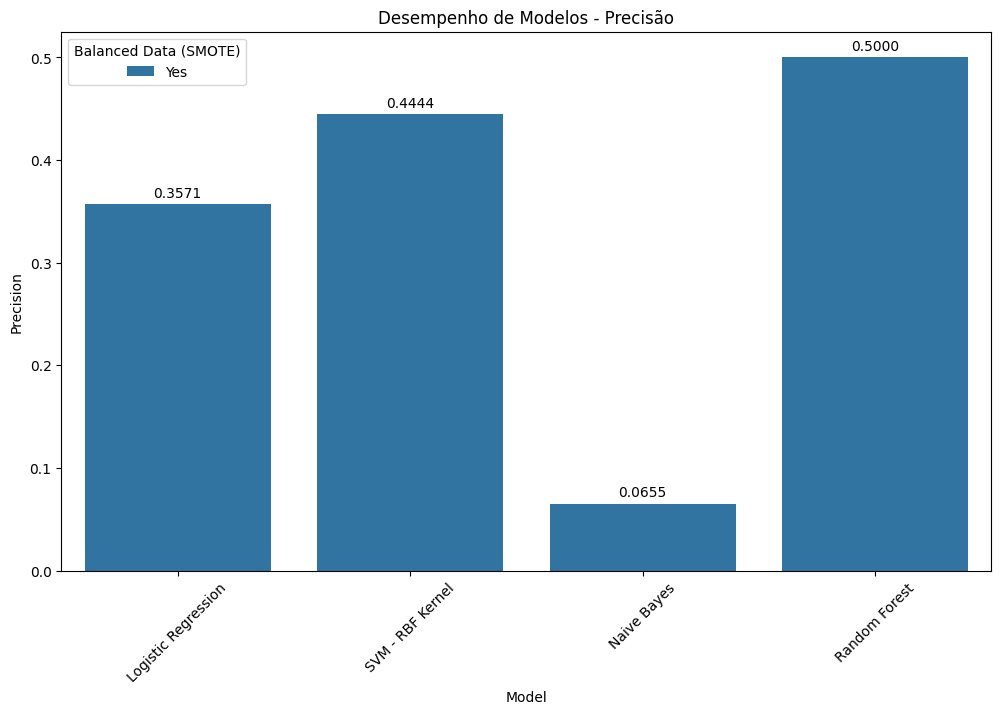

In [14]:
# RQ3: Comparação entre distribuições balanceadas e não balanceadas
plt.figure(figsize=(12, 7))
ax = sns.barplot(x="Model", y="Precision", hue="SMOTE", data=results_df)
plt.title("Desempenho de Modelos - Precisão")
plt.ylabel("Precision")
plt.xlabel("Model")
plt.legend(title="Balanced Data (SMOTE)")
plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3)

plt.show()

### Revocação

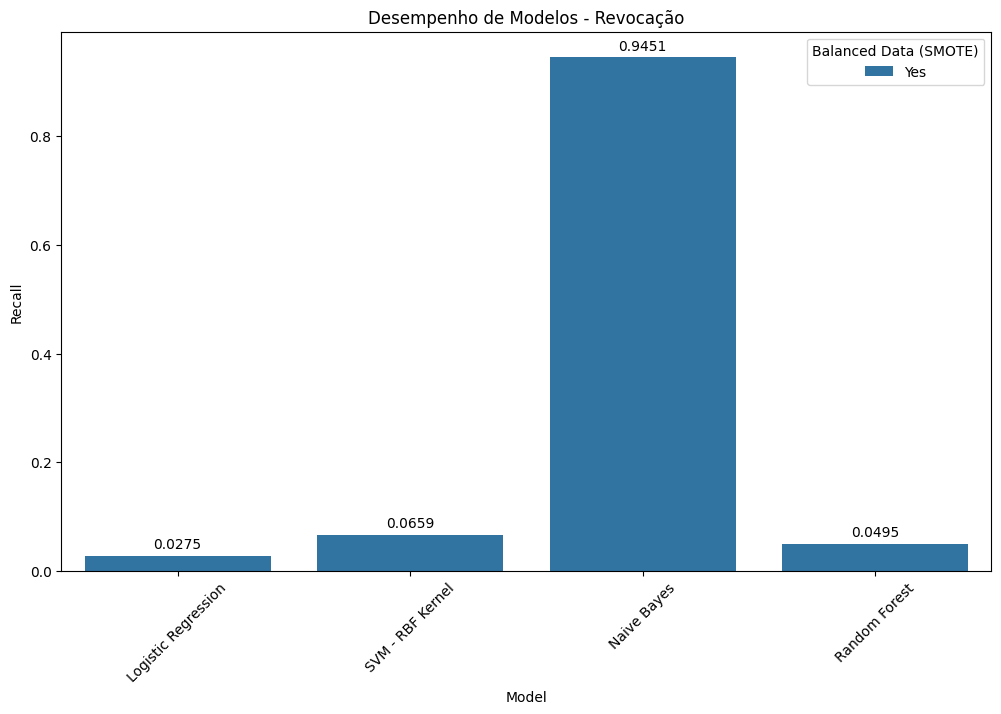

In [15]:
# RQ3: Comparação entre distribuições balanceadas e não balanceadas
plt.figure(figsize=(12, 7))
ax = sns.barplot(x="Model", y="Recall", hue="SMOTE", data=results_df)
plt.title("Desempenho de Modelos - Revocação")
plt.ylabel("Recall")
plt.xlabel("Model")
plt.legend(title="Balanced Data (SMOTE)")
plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3)

plt.show()